In [155]:
import pandas as pd
import seaborn as sns
import scipy.stats as st
import scipy
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import os

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split


In [156]:
if not os.path.exists('constituents-financials.csv'):
    urllib.request.urlretrieve("https://datahub.io/core/s-and-p-500-companies-financials/r/constituents-financials.csv", "constituents-financials.csv")


g:\Programming\itmo_algorithms\itmo\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
g:\Programming\itmo_algorithms\itmo\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
g:\Programming\itmo_algorithms\itmo\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

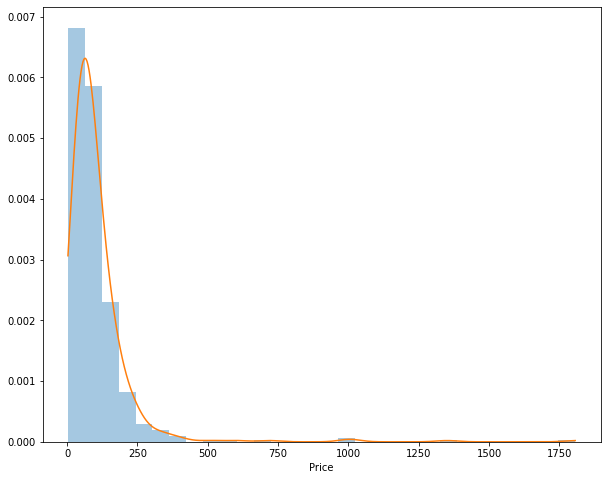

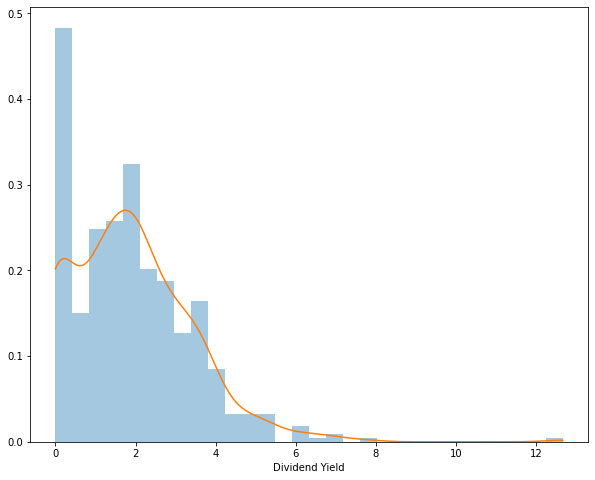

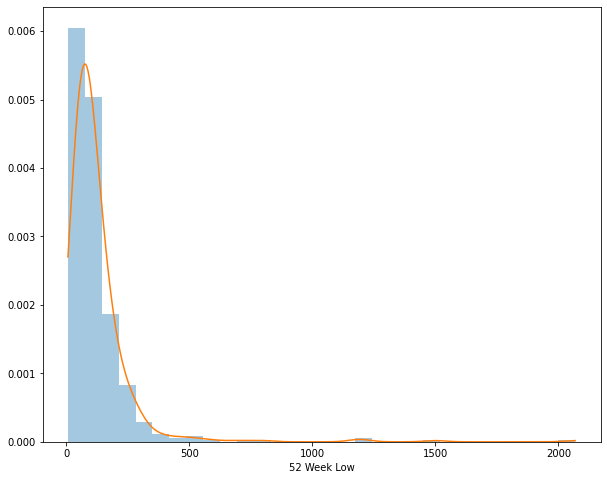

In [157]:
data = pd.read_csv('constituents-financials.csv')
nbins = 30

# Price
plt.figure(figsize=(10, 8))
kernel = st.gaussian_kde(data.Price)
min_amount, max_amount = data.Price.min(), data.Price.max()
x = np.linspace(min_amount, max_amount, len(data.Price))
kde_values = kernel(x)
sns.distplot(data.Price, kde=False, bins=nbins, norm_hist=True, label=f'Average price in dollars')
plt.plot(x, kde_values)

# Dividend Yield
plt.figure(figsize=(10, 8))
kernel = st.gaussian_kde(data['Dividend Yield'])
min_amount, max_amount = data['Dividend Yield'].min(), data['Dividend Yield'].max()
x = np.linspace(min_amount, max_amount, len(data['Dividend Yield']))
kde_values = kernel(x)
sns.distplot(data['Dividend Yield'], kde=False, bins=nbins, norm_hist=True, label=f'Average price in dollars')
plt.plot(x, kde_values)

# 52 week low
plt.figure(figsize=(10, 8))
kernel = st.gaussian_kde(data['52 Week Low'])
min_amount, max_amount = data['52 Week Low'].min(), data['52 Week Low'].max()
x = np.linspace(min_amount, max_amount, len(data['52 Week Low']))
kde_values = kernel(x)
sns.distplot(data['52 Week Low'], kde=False, bins=nbins, norm_hist=True, label=f'Average price in dollars')
plt.plot(x, kde_values)

In [158]:
subdataset = data[['Price', 'Dividend Yield', '52 Week Low']]
subdataset

,Price,Dividend Yield,52 Week Low
0,222.89,2.332862,259.77
1,60.24,1.147959,68.39
2,56.27,1.908982,64.60
3,108.48,2.499560,125.86
4,150.51,1.714470,162.60
...,...,...,...
500,70.24,1.170079,76.81
501,76.30,1.797080,86.93
502,115.53,0.794834,133.49
503,50.71,1.480933,55.61


In [159]:
print(subdataset.mean())
print(subdataset.var(ddof=1))

Price             103.830634
Dividend Yield      1.895953
52 Week Low       122.623832
dtype: float64
Price             18070.789338
Dividend Yield        2.363028
52 Week Low       24137.394494
dtype: float64


In [160]:
subdataset.corr()

,Price,Dividend Yield,52 Week Low
Price,1.000000,-0.244630,0.995076
Dividend Yield,-0.244630,1.000000,-0.244426
52 Week Low,0.995076,-0.244426,1.000000


In [161]:
pairs = [
    ['Price', 'Dividend Yield'],
    ['Price', '52 Week Low'],
    ['52 Week Low', 'Dividend Yield']
]
for x, y in pairs:
    print('Pair:', x, y)
    r, p = st.pearsonr(subdataset[x], subdataset[y])
    r_z = np.arctanh(r)  # matches Fisher transform
    # Corresponding standard deviation
    se = 1/np.sqrt(subdataset[x].size-3)
    alpha = 0.05
    z = st.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se

    print('Correlation coefficient = ', r)
    print('Confidence interval for the correlation coefficient ', lo_z, hi_z)


def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


Pair: Price Dividend Yield
Correlation coefficient =  -0.24462964683744529
Confidence interval for the correlation coefficient  -0.33717003834548215 -0.16221509091321062
Pair: Price 52 Week Low
Correlation coefficient =  0.9950764471454037
Confidence interval for the correlation coefficient  2.914726152856614 3.0896811002888858
Pair: 52 Week Low Dividend Yield
Correlation coefficient =  -0.24442592168172014
Confidence interval for the correlation coefficient  -0.336953356978414 -0.16199840954614247


# Conditional distributions

In [172]:
subdataset[(subdataset.Price==12.82) & ( subdataset['52 Week Low'] <= 259 )].shape[0] / subdataset[(subdataset.Price==12.82)].shape[0] 



1.0

# Without regularization

In [163]:
# Highlight predictors
X = subdataset[['Price', 'Dividend Yield']]
# Allocate the target variable
y = data[['52 Week Low']]
# Division into training and test samples
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

x = []
for i in range(len(y_test)):
    x.append(i)
# Create a linear regression model
reg = LinearRegression()
# Train a linear regression model
reg.fit(X_train, y_train)
# Forecast on a test sample
y_pred = reg.predict(X_test)
params = np.append(reg.intercept_, reg.coef_)
print('model parameters:')
print('model weights:', reg.coef_)
print('model bias:', reg.intercept_)


# Calculation of model metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print('Mean absolute error = ', mae)
print('Mean squared error = ', mse)
mape = mean_absolute_percentage_error(y_test, y_pred)
print('Mean absolute percentage error = ', mape.squeeze())
print('Determination coefficient = ', reg.score(X_test, y_test))



model parameters:
model weights: [[1.16132007 0.04906678]]
model bias: [2.39660458]
Mean absolute error =  6.481496620089051
Mean squared error =  128.21479852568262
Mean absolute percentage error =  6.566091594180154
Determination coefficient =  0.992984901575095


# With regularization, using only price

In [164]:
# Highlight predictors
X = subdataset[['Price']]
# Allocate the target variable
y = data[['52 Week Low']]
# Division into training and test samples
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

x = []
for i in range(len(y_test)):
    x.append(i)
# Create a linear regression model
reg = LinearRegression()
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
y_train = pd.DataFrame(scaler.fit_transform(y_train))
X_test = pd.DataFrame(scaler.fit_transform(X_test))
y_test = pd.DataFrame(scaler.fit_transform(y_test))
# Train a linear regression model
reg.fit(X_train, y_train)
# Forecast on a test sample
y_pred = reg.predict(X_test)
params = np.append(reg.intercept_, reg.coef_)
print('model parameters:')
print('model weights:', reg.coef_)
print('model bias:', reg.intercept_)


# Calculation of model metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print('Mean absolute error = ', mae)
print('Mean squared error = ', mse)
mape = mean_absolute_percentage_error(y_test, y_pred)
print('Mean absolute percentage error = ', mape.squeeze())
print('Determination coefficient = ', reg.score(X_test, y_test))


model parameters:
model weights: [[0.99451581]]
model bias: [-1.99247603e-16]
Mean absolute error =  0.04530415280121249
Mean squared error =  0.005473864737939061
Mean absolute percentage error =  75.14970071598513
Determination coefficient =  0.9945261352620609


# With regularization

In [165]:
# Highlight predictors
X = subdataset[['Price', 'Dividend Yield']]
# Allocate the target variable
y = data[['52 Week Low']]
# Division into training and test samples
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

x = []
for i in range(len(y_test)):
    x.append(i)
# Create a linear regression model
reg = LinearRegression()
# Train a linear regression model
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
y_train = pd.DataFrame(scaler.fit_transform(y_train))
X_test = pd.DataFrame(scaler.fit_transform(X_test))
y_test = pd.DataFrame(scaler.fit_transform(y_test))
reg.fit(X_train, y_train)
# Forecast on a test sample
y_pred = reg.predict(X_test)
params = np.append(reg.intercept_, reg.coef_)
print('model parameters:')
print('model weights:', reg.coef_)
print('model bias:', reg.intercept_)


# Calculation of model metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print('Mean absolute error = ', mae)
print('Mean squared error = ', mse)
mape = mean_absolute_percentage_error(y_test, y_pred)
print('Mean absolute percentage error = ', mape.squeeze())
print('Determination coefficient = ', reg.score(X_test, y_test))


model parameters:
model weights: [[9.94649187e-01 4.90803560e-04]]
model bias: [-1.99338458e-16]
Mean absolute error =  0.04529884328591078
Mean squared error =  0.0054763232563473695
Mean absolute percentage error =  74.98722020751066
Determination coefficient =  0.9945236767436526


g:\Programming\itmo_algorithms\itmo\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:>

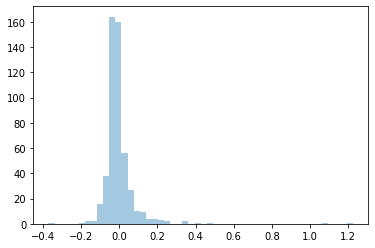

In [166]:
# Plotting the distribution of residuals
scaler = StandardScaler()
X = subdataset[['Price', 'Dividend Yield']]
X = pd.DataFrame(scaler.fit_transform(X))
y = data[['52 Week Low']]
y_pred_all = np.array(reg.predict(X))
y = pd.DataFrame(scaler.fit_transform(y))
y1 = np.array(y)
y2 = np.array(y_pred_all)
y_diff = y1[:,0] - y2[:,0]
sns.distplot(y_diff, kde=False)